# DL session 2 challenge: Gandalf or Dumbledore?


## Introduction
In this challenge we will train a neural network to distinguish between two different types of images using convolutional nerual networks.

In particular, we will train a model that can distinguish between images of Gandalf (from _Lord of the Rings_) and Dumbledore (from _Harry Potter_).

This is a challenging visual task for a few reasons:
 * Both are grey-bearded old white men
 * Both wear wizard robes and hats
 * Two different actors played Dumbledore (yes, we will ignore the Jude Law incarnation), Richard Harris and Michael Gambon, and they did not look very much alike. In fact, you could argue that Michael Gambon looks much more like Ian McKellen than like Richark Harris.
 * Gandalf has two incarnations that look significantly different: Gandalf the Grey and Gandalf the White

With a very limited training set of images, this task would be close to impossible if we were training a neural network from scratch.

Thankfully, but we will not start from scratch. We will use Transfer Learning to benefit from the representations learned by other networks previously trained on huge datasets with many image classes, and apply those representations to our much more specific problem, with much more limited data.

## Rules

 * Start by making your own copy of this notebook.
 * You are be provided with a very small training set of images form both classes. This is on purpose, so that you notice the power of Tranfer Learning.
 * You can use as much data augmentation as you want, and use any kind of inner split (train/validation split) for validation or cross-validation, but your can't add new images.
 * You can use whichever DL framework and API you want, although I suggest that you use Keras in this case.
 * You must set the seed of any pseudorandom functions
 * You must submit two files:
   * This notebook with your code, which should be abble to run from start to finish in Colab without any errors.
   * A file with your saved model. If you are usingn keras, this would be the output of `model.save("your-model-name.h5")`. The notebook should include code able to load this file correctly, which if you are using keras should be something like `model = tf.keras.models.load_model("your-model-name.h5")`
 * The models will be scored against a test set that I will keep hidden. The scoring metric will be binary accuracy. In keras this is `tf.keras.metrics.BinaryAccuracy`.
 * The submission with the higgest accuracy will win this week's prize. In case of a tie, we wil also evaluate by best practices and code quality.

## Suggested resources

 * Easy way to manipulate an image dataset with Keras: https://keras.io/api/preprocessing/image/
 * You will probably find this Transfer Learning example in Keras very useful: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
 * Data augmentation layers in Keras: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
 * There are many pre-trained state-of-art models available directly through the Keras API, such as EfficientNet: https://keras.io/api/applications/efficientnet/

## Setup

First, we will install and load all of the libraries we will be using.

Please update it as you need, importing whatever libraries you use in your code.

## Setup

Include any imports you need in the cell below.

I have included some imports to give you hints on what you might want to make use of.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split

import shutil

SEED = 1337  # Set this to whichever value you want and use this parameters in any seeded pseudorandom functions you use

## Dataset

You can download the training data by running the cell below. You will get the following folder structure:

```
train_data
 |_ dumbledore
    |_ dumbledore_0000.jpg
    |_ dumbledore_0001.jpg
    |_ dumbledore_0002.jpg
    |_ ...
 |_ gandalf
    |_ gandalf_0000.jpg
    |_ gandalf_0001.jpg
    |_ gandalf_0002.jpg
```

In [ ]:
def get_train_data():
    gdd.download_file_from_google_drive(
        file_id = '16uUSJevLSCx4DO5x-FQ-2jVv43HH5UcP',
        dest_path = './train_data.zip',
    )
    shutil.unpack_archive("./train_data.zip", extract_dir=".")

get_train_data()

In [ ]:
num_skipped = 0
for folder_name in ("dumbledore", "gandalf"):
    folder_path = os.path.join("/content/train_data/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 8 images.


In [ ]:
image_size = (224, 224)
# El batch size no debe ser mas gránde que el conjunto de datos
batch_size = 59

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/train_data/",
    validation_split=0.2,
    subset="both",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

Found 73 files belonging to 2 classes.
Using 59 files for training.
Using 14 files for validation.


In [ ]:
import os
images_dumbeldore = []

def resize(img, size):
    return img

for file in os.listdir('/content/train_data/dumbledore'):

    if file.endswith('.jpg'):
        img = plt.imread('/content/train_data/dumbledore/' + file)
        img = resize(img, (224, 224,3))
        images_dumbeldore.append(img)

In [ ]:
images_gandalf = []

def resize(img, size):
    return img

for file in os.listdir('/content/train_data/gandalf'):

    if file.endswith('.jpg'):
        img = plt.imread('/content/train_data/gandalf/' + file)
        img = resize(img, (224, 224,3))
        images_gandalf.append(img)

In [ ]:
print(len(images_gandalf))
print(len(images_dumbeldore))

36
37


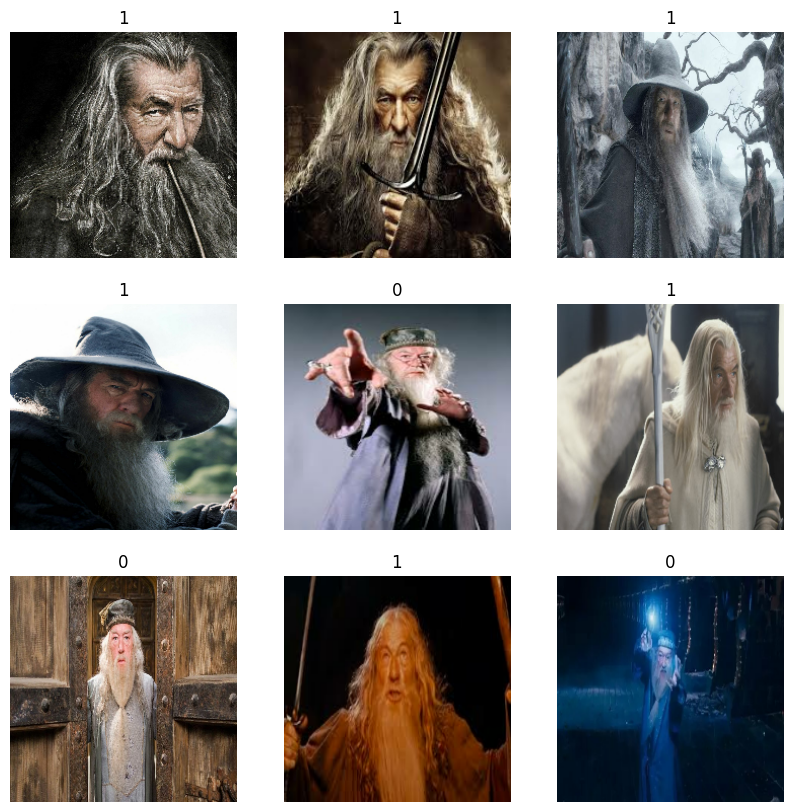

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
label_count = {}
for images, labels in train_ds:
    for l in labels:
        l = int(l)
        if l in label_count:
            label_count[l] += 1
        else:
            label_count[l] = 1
label_count

{1: 30, 0: 29}

In [ ]:
label_count = {}
for images, labels in val_ds:
    for l in labels:
        l = int(l)
        if l in label_count:
            label_count[l] += 1
        else:
            label_count[l] = 1
label_count

{0: 8, 1: 6}

### Data Augmentation

## Rotar, Zoom y voltear

In [ ]:
from keras import layers

img_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)]


def data_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

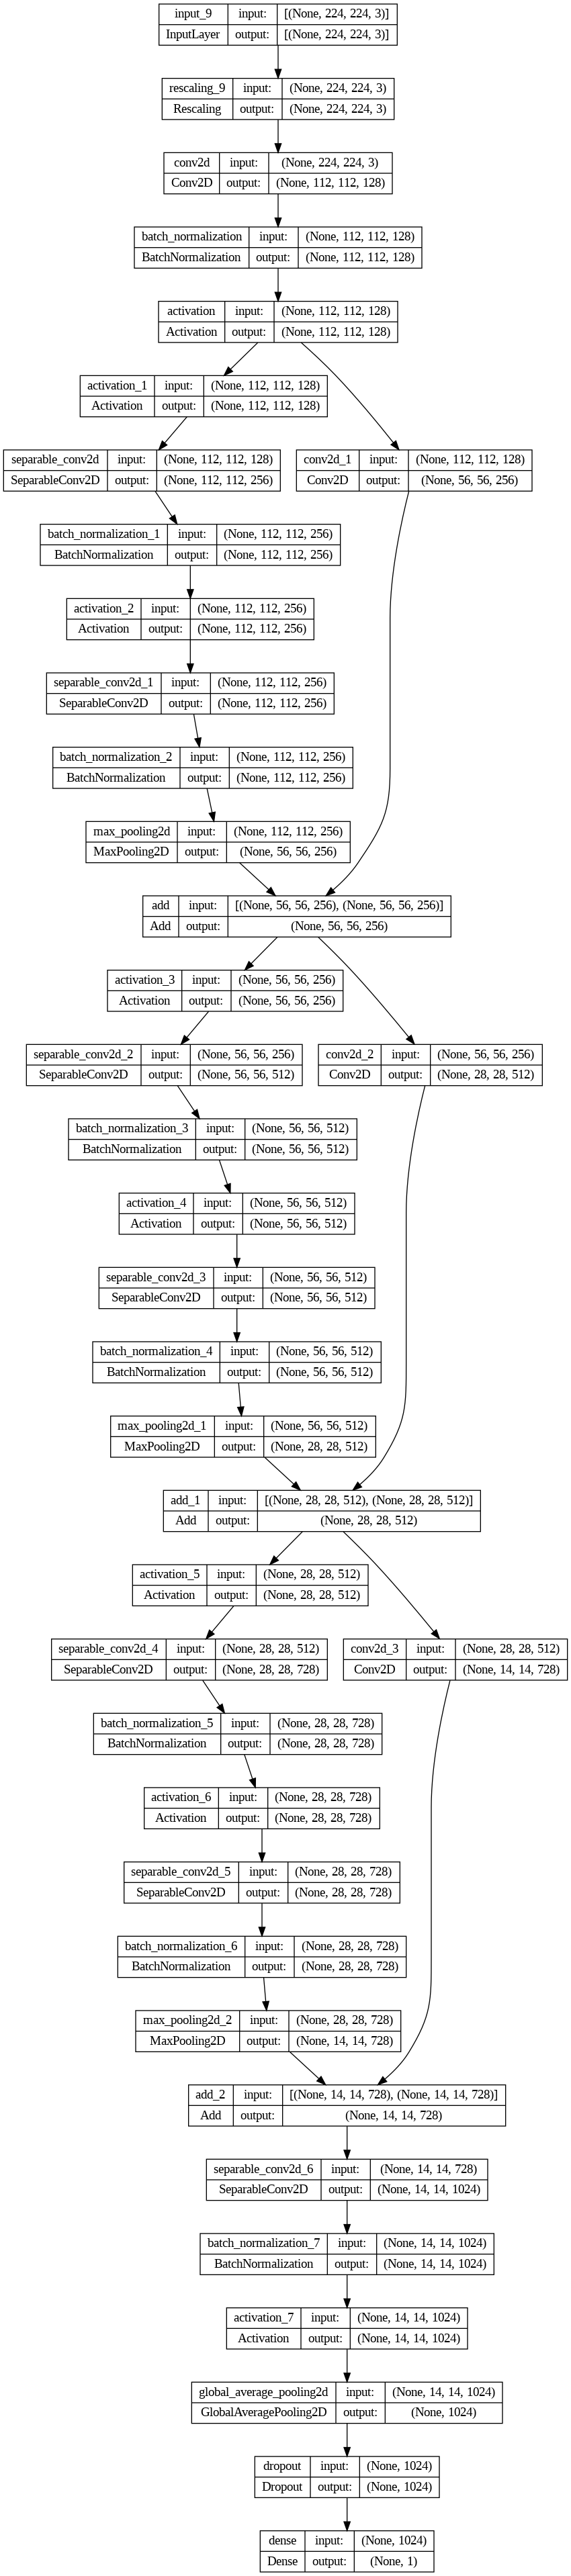

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
1/1 [==============================] - 70s 70s/step - loss: 0.7917 - acc: 0.4915 - val_loss: 0.6927 - val_acc: 0.5714
Epoch 2/25
1/1 [==============================] - 58s 58s/step - loss: 0.5784 - acc: 0.7119 - val_loss: 0.6924 - val_acc: 0.5714
Epoch 3/25
1/1 [==============================] - 56s 56s/step - loss: 0.4999 - acc: 0.7288 - val_loss: 0.6922 - val_acc: 0.5714
Epoch 4/25
1/1 [==============================] - 58s 58s/step - loss: 0.4832 - acc: 0.7458 - val_loss: 0.6920 - val_acc: 0.5714
Epoch 5/25
1/1 [==============================] - 56s 56s/step - loss: 0.4259 - acc: 0.7119 - val_loss: 0.6918 - val_acc: 0.5714
Epoch 6/25
1/1 [==============================] - 57s 57s/step - loss: 0.3744 - acc: 0.8305 - val_loss: 0.6917 - val_acc: 0.5714
Epoch 7/25
1/1 [==============================] - 57s 57s/step - loss: 0.3084 - acc: 0.8644 - val_loss: 0.6916 - val_acc: 0.5714
Epoch 8/25
1/1 [==============================] - 56s 56s/step - loss: 0.2790 - acc: 0.9322 - val

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)
model = EfficientNetB0(weights='imagenet')


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

In [ ]:
model.save('Greiffindor_DFL_Susana_David_ANdres.h5')